# 物体検出

参考にした本

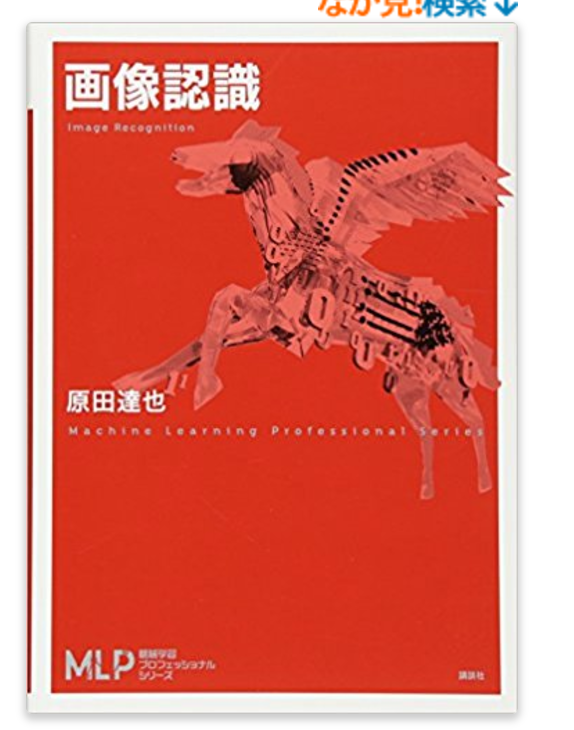

## バウンディングボックス or ウインドウ

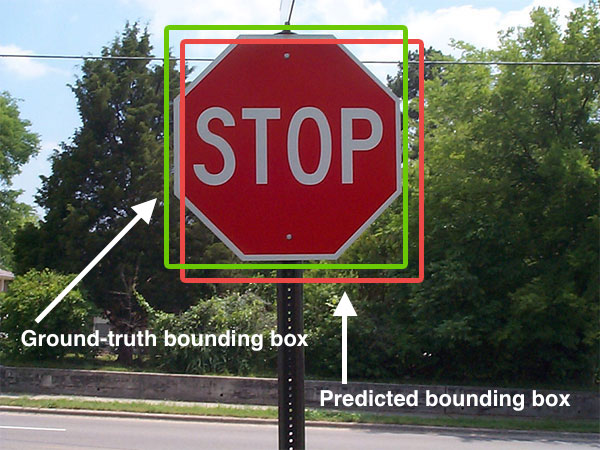

## 物体領域候補の提案

#### 1.スライディングウインドウ法

ある決まった大きさの領域を一定のピクセルごとにずらすことで領域候補を提案する。<br>

参考：　http://slideplayer.com/slide/9825356/


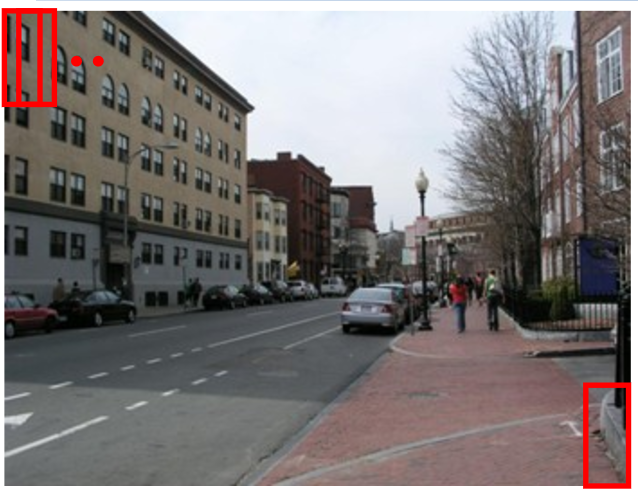

#### 2.selective search法

物体らしさをあらかじめ評価しておき、領域候補数を絞り込む。<br>
1.画像を小さい領域群に分割<br>
2.隣り合う領域の類似度を計算<br>
3.もっとも類似度の高い領域を結合<br>

# セグメンテーションとスーパーピクセルalgorithmsの例

Felzenszwalb number of segments: 194
SLIC number of segments: 190
Quickshift number of segments: 695


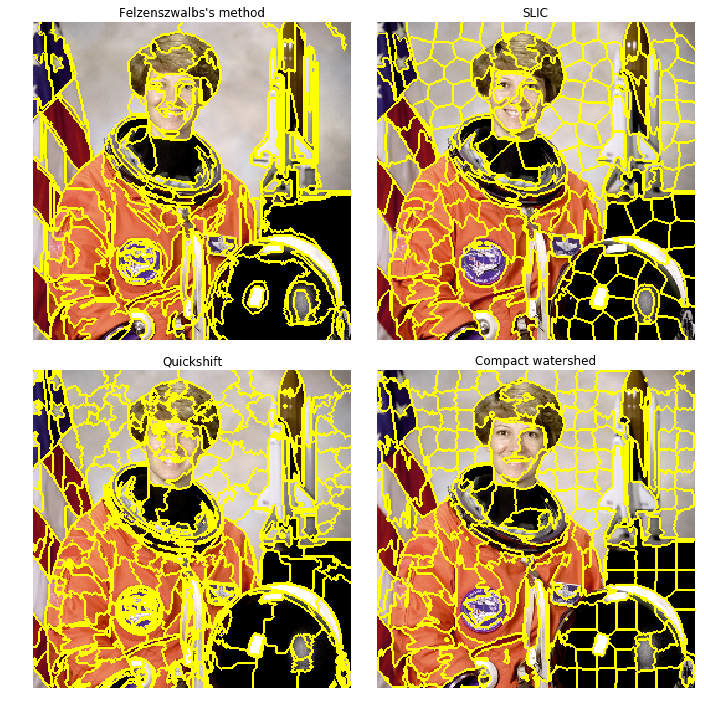

In [22]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
img = img_as_float(astronaut()[::2, ::2])
segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)
print("Felzenszwalb number of segments: {}".format(len(np.unique(segments_fz))))
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('Quickshift number of segments: {}'.format(len(np.unique(segments_quick))))
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'})
ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')
for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout()
plt.show()

# superpixel とは

In [ ]:
#似た傾向を持つ画素をひとまとめにした領域です．
#参考
#http://www.sanko-shoko.net/note.php?id=mpfg

## SLIC(Simple Linear Iterative Clustering)

アルゴリズム

- １．等間隔でsuperpixelの領域を決め，そのパラメータ（中心位置と色の情報）を初期化する
- ２．各画素の色と位置の情報を元に，どのsuperpixelに所属するかを決定する
- ３．各superpixelのパラメータを更新する



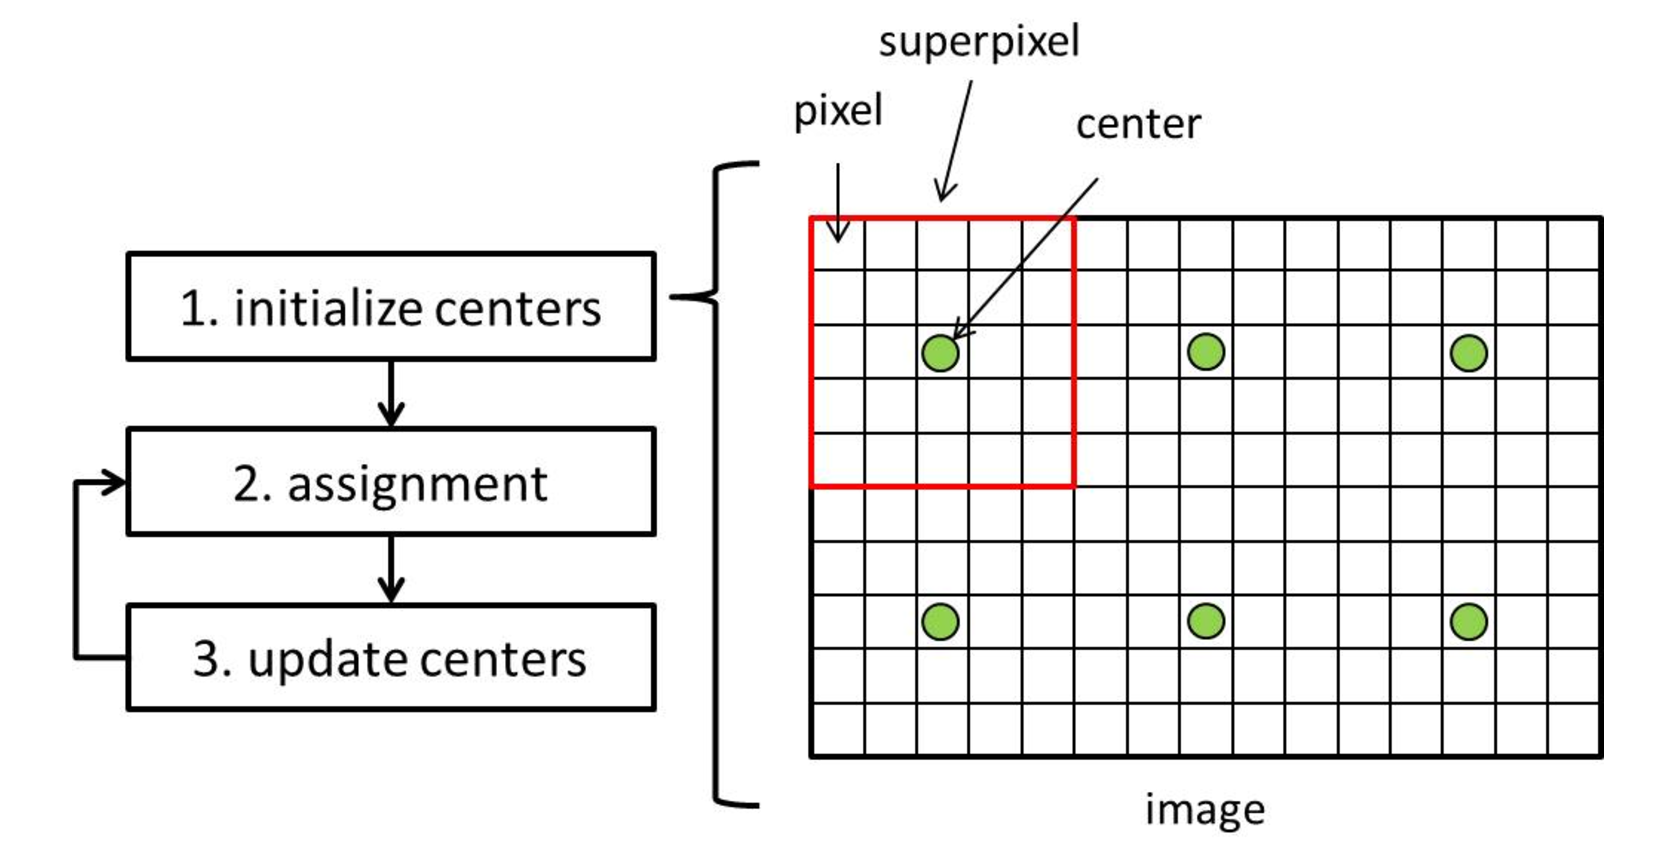

In [ ]:
#superpixelの歴史
#参考
#http://davidstutz.de/projects/superpixel-benchmark-2014/

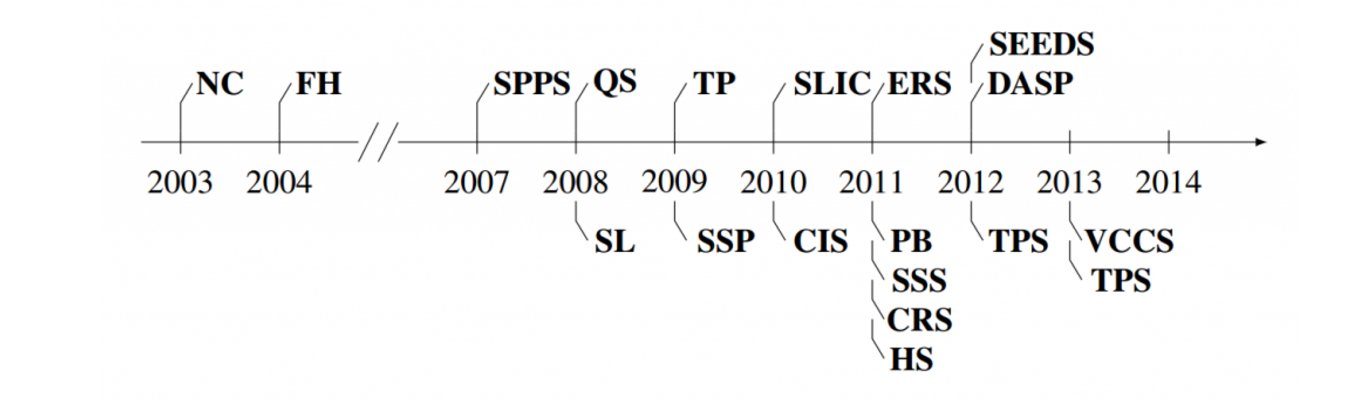

In [23]:
# img = img_as_float(astronaut()[::2, ::2])
# plt.imshow(np.array(img))

# selectivesearchについて

In [ ]:
#エラー中
#参考
#https://github.com/AlpacaDB/selectivesearch
import skimage.io
import skimage.feature
import skimage.color
import skimage.transform
import skimage.util
import skimage.segmentation
import numpy

def _generate_segments(im_orig, scale, sigma, min_size):
    # open the Image
    im_mask = skimage.segmentation.felzenszwalb(
        skimage.util.img_as_float(im_orig), scale=scale, sigma=sigma,
        min_size=min_size)

    # merge mask channel to the image as a 4th channel
    im_orig = numpy.append(
        im_orig, numpy.zeros(im_orig.shape[:2])[:, :, numpy.newaxis], axis=2)
    im_orig[:, :, 3] = im_mask

    return im_orig

def _sim_colour(r1, r2):
    return sum([min(a, b) for a, b in zip(r1["hist_c"], r2["hist_c"])])


def _sim_texture(r1, r2):
    return sum([min(a, b) for a, b in zip(r1["hist_t"], r2["hist_t"])])


def _sim_size(r1, r2, imsize):
    return 1.0 - (r1["size"] + r2["size"]) / imsize


def _sim_fill(r1, r2, imsize):
    bbsize = (
        (max(r1["max_x"], r2["max_x"]) - min(r1["min_x"], r2["min_x"]))
        * (max(r1["max_y"], r2["max_y"]) - min(r1["min_y"], r2["min_y"]))
    )
    return 1.0 - (bbsize - r1["size"] - r2["size"]) / imsize


def _calc_sim(r1, r2, imsize):
    return (_sim_colour(r1, r2) + _sim_texture(r1, r2)
            + _sim_size(r1, r2, imsize) + _sim_fill(r1, r2, imsize))


def _calc_colour_hist(img):
    BINS = 25
    hist = numpy.array([])

    for colour_channel in (0, 1, 2):

        # extracting one colour channel
        c = img[:, colour_channel]

        # calculate histogram for each colour and join to the result
        hist = numpy.concatenate(
            [hist] + [numpy.histogram(c, BINS, (0.0, 255.0))[0]])

    # L1 normalize
    hist = hist / len(img)

    return hist


def _calc_texture_gradient(img):
    ret = numpy.zeros((img.shape[0], img.shape[1], img.shape[2]))

    for colour_channel in (0, 1, 2):
        ret[:, :, colour_channel] = skimage.feature.local_binary_pattern(
            img[:, :, colour_channel], 8, 1.0)

    return ret

def _calc_texture_hist(img):
    BINS = 10

    hist = numpy.array([])

    for colour_channel in (0, 1, 2):

        # mask by the colour channel
        fd = img[:, colour_channel]

        # calculate histogram for each orientation and concatenate them all
        # and join to the result
        hist = numpy.concatenate(
            [hist] + [numpy.histogram(fd, BINS, (0.0, 1.0))[0]])

    # L1 Normalize
    hist = hist / len(img)
    return hist

def _extract_regions(img):
    R = {}

    # get hsv image
    hsv = skimage.color.rgb2hsv(img[:, :, :3])
    # pass 1: count pixel positions
    for y, i in enumerate(img):
        for x, (r, g, b, l) in enumerate(i):
            
            # initialize a new region
            if l not in R:
                R[l] = {
                    "min_x": 0xffff, "min_y": 0xffff,
                    "max_x": 0, "max_y": 0, "labels": [l]}

            # bounding box
            if R[l]["min_x"] > x:
                R[l]["min_x"] = x
            if R[l]["min_y"] > y:
                R[l]["min_y"] = y
            if R[l]["max_x"] < x:
                R[l]["max_x"] = x
            if R[l]["max_y"] < y:
                R[l]["max_y"] = y

    print("1!")
    
    # pass 2: calculate texture gradient
    tex_grad = _calc_texture_gradient(img)

    print("2!")
    
    # pass 3: calculate colour histogram of each region
    for k, v in R.items():

        # colour histogram
        masked_pixels = hsv[:, :, :][img[:, :, 3] == k]
        R[k]["size"] = len(masked_pixels / 4)
        R[k]["hist_c"] = _calc_colour_hist(masked_pixels)

        # texture histogram
        R[k]["hist_t"] = _calc_texture_hist(tex_grad[:, :][img[:, :, 3] == k])

    print("3!")
    
    return R


def _extract_neighbours(regions):

    def intersect(a, b):
        if (a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]):
            return True
        return False

    print(type(regions))
    
    R = regions.items()
    
    
    print(R[:-1])

        
    neighbours = []
    for cur, a in enumerate(R[:-1]):
        for b in R[cur + 1:]:
            if intersect(a[1], b[1]):
                neighbours.append((a, b))

    return neighbours


def _merge_regions(r1, r2):
    new_size = r1["size"] + r2["size"]
    rt = {
        "min_x": min(r1["min_x"], r2["min_x"]),
        "min_y": min(r1["min_y"], r2["min_y"]),
        "max_x": max(r1["max_x"], r2["max_x"]),
        "max_y": max(r1["max_y"], r2["max_y"]),
        "size": new_size,
        "hist_c": (
            r1["hist_c"] * r1["size"] + r2["hist_c"] * r2["size"]) / new_size,
        "hist_t": (
            r1["hist_t"] * r1["size"] + r2["hist_t"] * r2["size"]) / new_size,
        "labels": r1["labels"] + r2["labels"]
    }
    return rt


def selective_search(im_orig, scale=1.0, sigma=0.8, min_size=50):
    assert im_orig.shape[2] == 3, "3ch image is expected"

    # load image and get smallest regions
    # region label is stored in the 4th value of each pixel [r,g,b,(region)]
    img = _generate_segments(im_orig, scale, sigma, min_size)

    if img is None:
        return None, {}

    imsize = img.shape[0] * img.shape[1]
    R = _extract_regions(img)

    print("R1!")
    
    # extract neighbouring information
    neighbours = _extract_neighbours(R)

    print("R2!")
    
    # calculate initial similarities
    S = {}
    for (ai, ar), (bi, br) in neighbours:
        S[(ai, bi)] = _calc_sim(ar, br, imsize)

    print("R3!")
    
    # hierarchal search
    while S != {}:

        # get highest similarity
        i, j = sorted(S.items(), cmp=lambda a, b: cmp(a[1], b[1]))[-1][0]

        # merge corresponding regions
        t = max(R.keys()) + 1.0
        R[t] = _merge_regions(R[i], R[j])

        # mark similarities for regions to be removed
        key_to_delete = []
        for k, v in S.items():
            if (i in k) or (j in k):
                key_to_delete.append(k)

        # remove old similarities of related regions
        for k in key_to_delete:
            del S[k]

        # calculate similarity set with the new region
        for k in filter(lambda a: a != (i, j), key_to_delete):
            n = k[1] if k[0] in (i, j) else k[0]
            S[(t, n)] = _calc_sim(R[t], R[n], imsize)

    regions = []
    for k, r in R.items():
        regions.append({
            'rect': (
                r['min_x'], r['min_y'],
                r['max_x'] - r['min_x'], r['max_y'] - r['min_y']),
            'size': r['size'],
            'labels': r['labels']
        })

    return img, regions

In [14]:
import skimage.data
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def main():

    # loading astronaut image
    img = skimage.data.astronaut()

    # perform selective search
    img_lbl, regions = selective_search(
        img, scale=500, sigma=0.9, min_size=10)

    candidates = set()
    for r in regions:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < 2000:
            continue
        # distorted rects
        x, y, w, h = r['rect']
        if w / h > 1.2 or h / w > 1.2:
            continue
        candidates.add(r['rect'])

    # draw rectangles on the original image
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img)
    for x, y, w, h in candidates:
        print(x, y, w, h)
        rect = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    plt.show()
    
if __name__ == "__main__":
    main()

1!
2!
3!
R1!
<class 'dict'>


TypeError: 'dict_items' object is not subscriptable